In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED
adp.SetStyle()

# Data

In [2]:

def UnpackTable(fname: str) -> dict[str,np.array]:
    """Get a table dictionary like {x: xdata, y: ydata} from a CSV file containing data""" 
    # get data from the csv file
    arr = np.genfromtxt(fname, delimiter=",", dtype=str)
    # separate column names and data arrays 
    cols = np.array(arr[0 ], dtype=str)
    data = np.array(arr[1:]).T # transpose to get x and y
    # build dictionary to hold the table {x: xdata, y: ydata}
    table = {}
    for col, dat in zip(cols,data) : 
        table[col] = dat
    return table

In [3]:
# get data
f = UnpackTable(adp.path_csv+'\\AGN_NH_estimates_Kelly+2024_update_COSMOS.csv')
for k,v in f.items() :
    if(k == 'ID') : 
        f[k] = np.array(v, dtype=int)
    elif(k == 'GROUP') : 
        f[k] = np.array(v, dtype=str)
    else :
        f[k] = np.array(v, dtype=float)

print(list(f.keys()))

['ID', 'GROUP', 'Z', 'LOG_LIR', 'LOG_LX_INT', 'LOG_LX', 'LOG_LXLIM', 'LOG_LXIR_THEORY', 'LOG_NH_THEORY', 'SIG_POS_THEORY', 'SIG_NEG_THEORY', 'LOG_LXIR_INTRIN', 'LOG_NH_INTRIN', 'SIG_POS_INTRIN', 'SIG_NEG_INTRIN', 'LOG_NH_COSMOS']


In [4]:
def SplitByColor(dataNew: dict) -> dict : 
    agnInfo = {}
    for color in ['RED', 'GRN', 'BLU'] : 
        idx = np.where(dataNew['GROUP'] == color)

        agnInfo[color] = {}
        for key, val in dataNew.items() : 
            agnInfo[color][key] = val[idx]

    return agnInfo

agnInfo = SplitByColor(f)

In [5]:
def GetNHestimatesWhereCOSMOSisNan(agnInfo) : 

    agnNH_nCOS = {}
    agnNH_yCOS = {} 

    for color, f in agnInfo.items() : 

        maskIsNan = np.isnan(f['LOG_NH_COSMOS'])
        maskIsNotNan = ~maskIsNan

        agnNH_nCOS[color] = {}
        agnNH_yCOS[color] = {}

        for key, val in f.items() :
            agnNH_nCOS[color][key] = val[maskIsNan] 
            agnNH_yCOS[color][key] = val[maskIsNotNan] 
            
        print(color, "\t\t(sum: \t", str(len(agnNH_nCOS[color]['ID']) + len(agnNH_yCOS[color]['ID'])), ")")
        print("isNan in COSMOS:\t", len(agnNH_nCOS[color]['ID']))
        print("has COSMOS NH:\t\t",   len(agnNH_yCOS[color]['ID']))
        
    return (agnNH_nCOS, agnNH_yCOS)

agnNH_nCOS, agnNH_yCOS = GetNHestimatesWhereCOSMOSisNan(agnInfo)

RED 		(sum: 	 422 )
isNan in COSMOS:	 409
has COSMOS NH:		 13
GRN 		(sum: 	 671 )
isNan in COSMOS:	 59
has COSMOS NH:		 612
BLU 		(sum: 	 1638 )
isNan in COSMOS:	 233
has COSMOS NH:		 1405


# Hists

In [34]:
def AxMakeHist(ax,
    x_red,
    x_grn,
    x_blu,
    bins  : np.array = np.arange(21,25,0.25),
    h     : int = 275,
    modeKey : int = 1
) : 
    
    ax.hist(x_blu, bins=bins, histtype='step', color=adp.c_xray,     linewidth=2)
    ax.hist(x_grn, bins=bins, histtype='step', color=adp.c_ir_xray,  linewidth=2)
    ax.hist(x_red, bins=bins, histtype='step', color=adp.c_ir,       linewidth=2)

    ax.set_ylim(0,h)
    ax.set_xlim(bins[0]-0.25,bins[-1]+0.25)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))

    if(modeKey == 1) : 
        adp.MeanLineForHist_ax(ax, x=x_red,c=adp.darken_color(adp.c_ir,      1.15), xtext=1.005,ytext=0.94,horizAlign='left',pre='')
        adp.MeanLineForHist_ax(ax, x=x_grn,c=adp.darken_color(adp.c_ir_xray, 1.15), xtext=1.002,ytext=0.94,horizAlign='left',pre='')
        adp.MeanLineForHist_ax(ax, x=x_blu,c=adp.darken_color(adp.c_xray,    1.15), xtext=1.005,ytext=0.94,horizAlign='left',pre='')
    elif(modeKey == 2) : 
        adp.MeanLineForHist_ax(ax, x=x_red,c=adp.darken_color(adp.c_ir,      1.15), xtext=0.995,ytext=0.94,horizAlign='right',pre='')
        adp.MeanLineForHist_ax(ax, x=x_grn,c=adp.darken_color(adp.c_ir_xray, 1.15), xtext=0.985,ytext=0.88,horizAlign='right',pre='')
        adp.MeanLineForHist_ax(ax, x=x_blu,c=adp.darken_color(adp.c_xray,    1.15), xtext=1.005,ytext=0.94,horizAlign='left',pre='')
    elif(modeKey == 3) :
        adp.MeanLineForHist_ax(ax, x=x_red,c=adp.darken_color(adp.c_ir,      1.15), xtext=1.005,ytext=0.94,horizAlign='left',pre='')
        adp.MeanLineForHist_ax(ax, x=x_grn,c=adp.darken_color(adp.c_ir_xray, 1.15), xtext=0.995,ytext=0.94,horizAlign='right',pre='')
        adp.MeanLineForHist_ax(ax, x=x_blu,c=adp.darken_color(adp.c_xray,    1.15), xtext=1.005,ytext=0.94,horizAlign='left',pre='')

def MakeHist(
    x_red,
    x_grn,
    x_blu,
    bins  : np.array = np.arange(21,25,0.25),
    h     : int = 275,
    modeKey : int = 1,
    save  : str = ''
) : 
    ax = plt.gca()
    AxMakeHist(ax, x_red, x_grn, x_blu, bins , h, modeKey )

    plt.xlabel('$\log ( N_H \, [cm^{-2}])$')
    plt.ylabel('Number')

    if(save != '') : adp.Save(save)
    plt.show()
    plt.close()
    

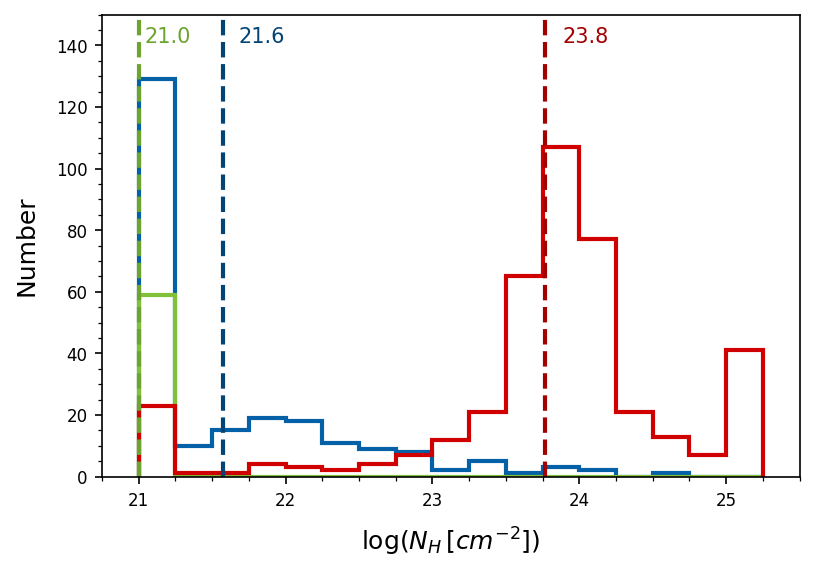

In [37]:
MakeHist(    
    x_red = agnNH_nCOS['RED']['LOG_NH_INTRIN'],
    x_grn = agnNH_nCOS['GRN']['LOG_NH_INTRIN'],
    x_blu = agnNH_nCOS['BLU']['LOG_NH_INTRIN'],
    bins  = np.arange(21,25.5,0.25),
    h     = 150,
    modeKey = 1,
    save  = adp.path_fig + '\\NHhist_COSMOSisNan_ChisEstim.pdf'
)

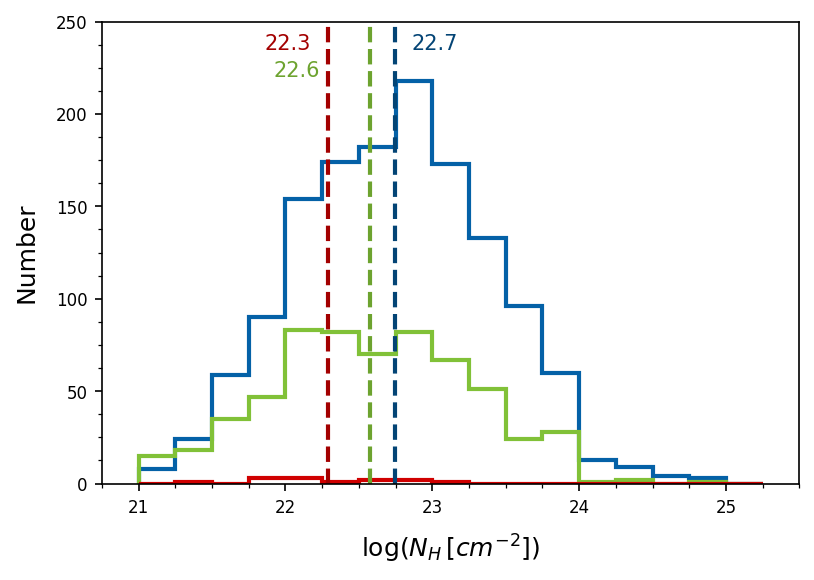

In [38]:
MakeHist(    
    x_red = agnNH_yCOS['RED']['LOG_NH_COSMOS'],
    x_grn = agnNH_yCOS['GRN']['LOG_NH_COSMOS'],
    x_blu = agnNH_yCOS['BLU']['LOG_NH_COSMOS'],
    bins  = np.arange(21,25.5,0.25),
    h     = 250,
    modeKey = 2,
    save  = adp.path_fig + '\\NHhist_COSMOSnotNan.pdf'
)

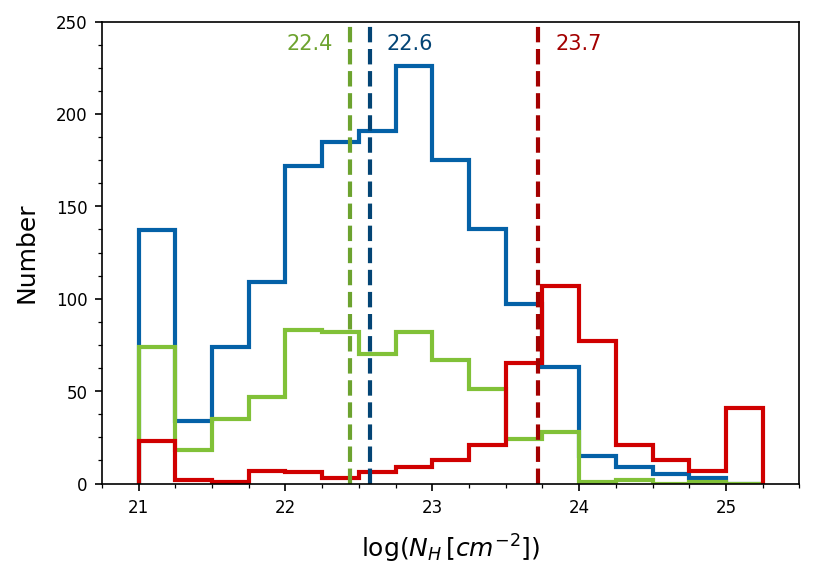

In [43]:
def MakeHist_Combined(agnNH_yCOS, agnNH_nCOS, save='') : 
    
    x_red_y = agnNH_yCOS['RED']['LOG_NH_COSMOS']
    x_grn_y = agnNH_yCOS['GRN']['LOG_NH_COSMOS']
    x_blu_y = agnNH_yCOS['BLU']['LOG_NH_COSMOS']
    
    x_red_n = agnNH_nCOS['RED']['LOG_NH_INTRIN']
    x_grn_n = agnNH_nCOS['GRN']['LOG_NH_INTRIN']
    x_blu_n = agnNH_nCOS['BLU']['LOG_NH_INTRIN']

    x_red_a = np.concatenate((x_red_y,x_red_n))
    x_grn_a = np.concatenate((x_grn_y,x_grn_n))
    x_blu_a = np.concatenate((x_blu_y,x_blu_n))

    bins  = np.arange(21,25.5,0.25)
    h     = 250

    MakeHist(x_red_a, x_grn_a, x_blu_a, bins , h, 3, save )

MakeHist_Combined(agnNH_yCOS, agnNH_nCOS, adp.path_fig + '\\NHhist_COSMOSchris_Combined.pdf')

# Multipanel

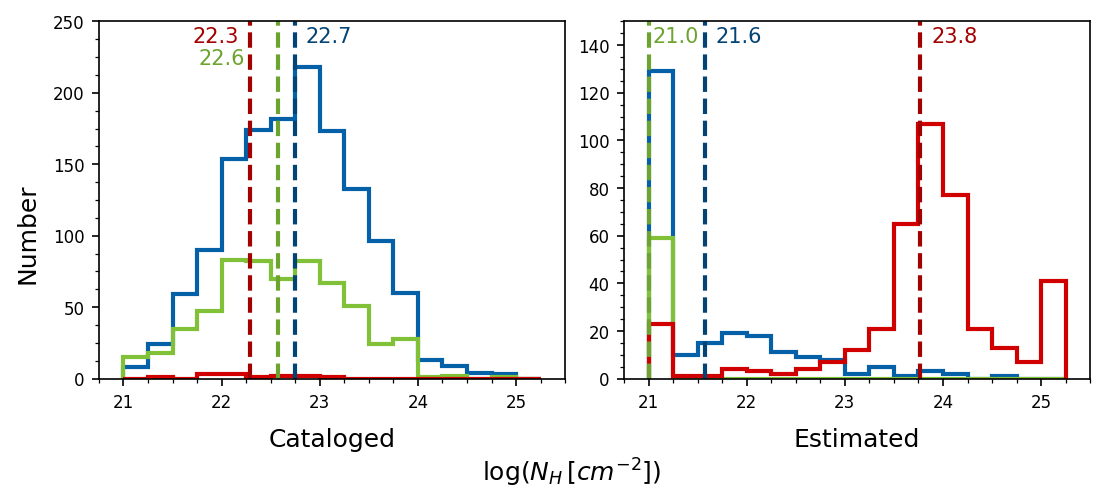

In [40]:
def MoreHists(agnNH_nCOS, agnNH_yCOS, save=''):

    fig, ax = adp.ByZ_SetupFig(2, False, 3, sharex=False, sharey=False)

    x_red = agnNH_yCOS['RED']['LOG_NH_COSMOS']
    x_grn = agnNH_yCOS['GRN']['LOG_NH_COSMOS']
    x_blu = agnNH_yCOS['BLU']['LOG_NH_COSMOS']
    bins  = np.arange(21,25.5,0.25)
    h     = 250
    AxMakeHist(ax[0], x_red, x_grn, x_blu, bins , h, 2 )    
    ax[0].set_xlabel('Cataloged')
    
    x_red = agnNH_nCOS['RED']['LOG_NH_INTRIN']
    x_grn = agnNH_nCOS['GRN']['LOG_NH_INTRIN']
    x_blu = agnNH_nCOS['BLU']['LOG_NH_INTRIN']
    bins  = np.arange(21,25.5,0.25)
    h     = 150
    AxMakeHist(ax[1], x_red, x_grn, x_blu, bins , h, 1 )
    ax[1].set_xlabel('Estimated')


    xpos=(0.5, -0.05)
    ypos=(-0.03,  0.5)
    adp.ByZ_FinishPlot(
            fig,
            '$\log ( N_H \, [cm^{-2}])$',
            'Number',
            save, xpos, ypos
        )


MoreHists(agnNH_nCOS, agnNH_yCOS, adp.path_fig + '\\NHhist_both.pdf')

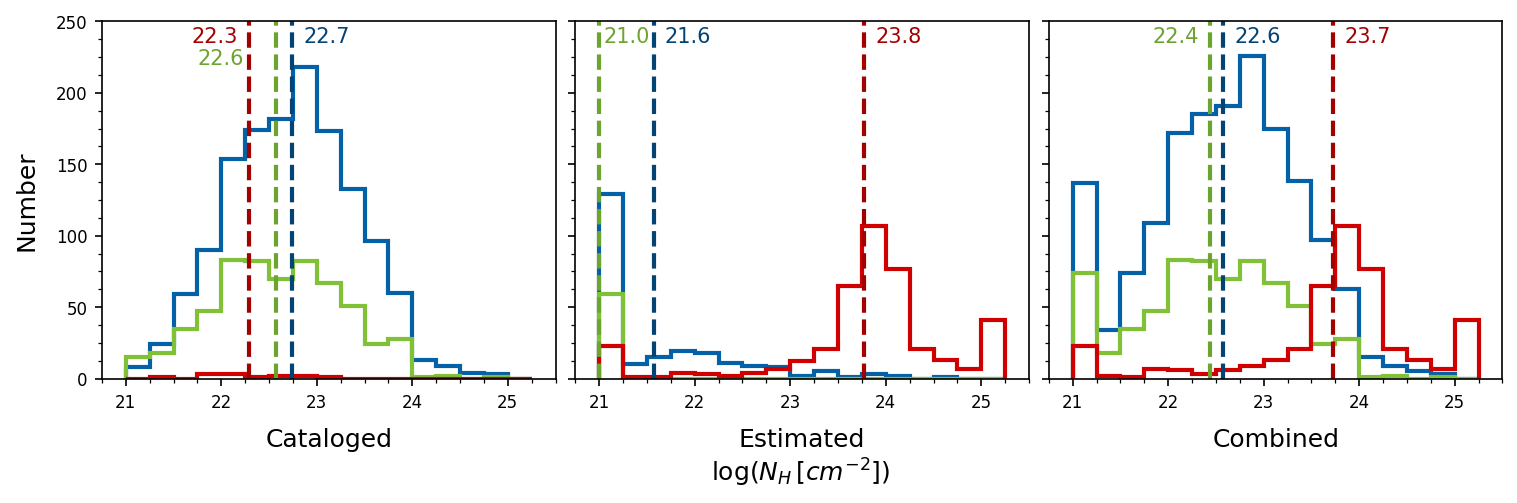

In [41]:
def CombinedHists(agnNH_nCOS, agnNH_yCOS, save=''):

    fig, ax = adp.ByZ_SetupFig(3, False, 3, sharex=False, sharey=True)

    x_red_y = agnNH_yCOS['RED']['LOG_NH_COSMOS']
    x_grn_y = agnNH_yCOS['GRN']['LOG_NH_COSMOS']
    x_blu_y = agnNH_yCOS['BLU']['LOG_NH_COSMOS']
    bins  = np.arange(21,25.5,0.25)
    h     = 250
    AxMakeHist(ax[0], x_red_y, x_grn_y, x_blu_y, bins , h, 2 )    
    ax[0].set_xlabel('Cataloged')
    ax[0].set_ylabel('Number')
    
    x_red_n = agnNH_nCOS['RED']['LOG_NH_INTRIN']
    x_grn_n = agnNH_nCOS['GRN']['LOG_NH_INTRIN']
    x_blu_n = agnNH_nCOS['BLU']['LOG_NH_INTRIN']
    bins  = np.arange(21,25.5,0.25)
    # h     = 250
    AxMakeHist(ax[1], x_red_n, x_grn_n, x_blu_n, bins , h, 1 )
    ax[1].set_xlabel('Estimated')

    x_red_a = np.concatenate((x_red_y,x_red_n))
    x_grn_a = np.concatenate((x_grn_y,x_grn_n))
    x_blu_a = np.concatenate((x_blu_y,x_blu_n))
    bins  = np.arange(21,25.5,0.25)
    # h     = 250
    AxMakeHist(ax[2], x_red_a, x_grn_a, x_blu_a, bins , h, 3 )
    ax[2].set_xlabel('Combined')


    xpos=(0.528, -0.05)
    ypos=(-0.03,  0.5)
    adp.ByZ_FinishPlot(
            fig,
            '$\log ( N_H \, [cm^{-2}])$',
            '',
            save, xpos, ypos
        )


CombinedHists(agnNH_nCOS, agnNH_yCOS, adp.path_fig + '\\NHhist_bothComb.pdf')

In [42]:
def TheComptons(agnNH, k='LOG_NH_COSMOS'):
    
    x_red = agnNH['RED'][k]
    x_grn = agnNH['GRN'][k]
    x_blu = agnNH['BLU'][k]
    x_red_c = x_red > 24.0
    x_grn_c = x_grn > 24.0
    x_blu_c = x_blu > 24.0
    print("RED:\t", sum(x_red_c), '/', len(x_red), '\t=', round(sum(x_red_c)/len(x_red)*100., 4), '%' )
    print("GRN:\t", sum(x_grn_c), '/', len(x_grn), '\t=', round(sum(x_grn_c)/len(x_grn)*100., 4), '%' )
    print("BLU:\t", sum(x_blu_c), '/', len(x_blu), '\t=', round(sum(x_blu_c)/len(x_blu)*100., 4), '%' )
    xc = sum(x_red_c)+sum(x_grn_c)+sum(x_blu_c)
    xs = len(x_red)+len(x_grn)+len(x_blu)
    print("ALL:\t", xc, '/', xs, '\t=', round(xc/xs*100., 4), '%' )

print('CATALOGED')
TheComptons(agnNH_yCOS, 'LOG_NH_COSMOS')
print('------------------------------------')
print('ESTIMATED')
TheComptons(agnNH_nCOS, 'LOG_NH_INTRIN')



CATALOGED
RED:	 0 / 13 	= 0.0 %
GRN:	 4 / 612 	= 0.6536 %
BLU:	 29 / 1405 	= 2.0641 %
ALL:	 33 / 2030 	= 1.6256 %
------------------------------------
ESTIMATED
RED:	 159 / 409 	= 38.8753 %
GRN:	 0 / 59 	= 0.0 %
BLU:	 3 / 233 	= 1.2876 %
ALL:	 162 / 701 	= 23.1098 %


In [3]:
print('------------------------------------')
print('COMBINED')
print("RED:\t", 0 +159, '/',   13 + 409, '\t=', round( (0 +159)/(  13 + 409)*100, 4), '%' )
print("GRN:\t", 4 +  0, '/',  612 +  59, '\t=', round( (4 +  0)/( 612 +  59)*100, 4), '%' )
print("BLU:\t", 29+  3, '/', 1405 + 233, '\t=', round( (29+  3)/(1405 + 233)*100, 4), '%' )

------------------------------------
COMBINED
RED:	 159 / 422 	= 37.6777 %
GRN:	 4 / 671 	= 0.5961 %
BLU:	 32 / 1638 	= 1.9536 %


In [4]:
print("XRAY:\t", 4+32, '/', 671+1638 	, '\t=', round( (4+32)/(671+1638)*100, 4), '%' )

XRAY:	 36 / 2309 	= 1.5591 %
